In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor
from lmfit import Model
from xgboost import XGBRegressor
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import neighbors
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import mutual_info_regression,f_regression
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
import umap

pl.style.use('seaborn')
pl.rc('font',family='Arial')

### Notes:
- https://machinelearningmastery.com/feature-selection-machine-learning-python/
- https://scikit-learn.org/stable/modules/feature_selection.html
- https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

## Read in and clean data

In [2]:
train_data = pd.read_csv("SubCh1_TrainingData.csv")
test_data = pd.read_csv("SubCh1_TestData.csv")

train_data['Timepoint'] = [1 if i == '24HR' else 0 for i in train_data['Timepoint']]
train_data['Treatment'] = [1 if i == 'DHA' else 0 for i in train_data['Treatment']]
train_data['BioRep'] = [int(i[-1]) for i in train_data['BioRep']]

test_data['Timepoint'] = [1 if i == '24HR' else 0 for i in test_data['Timepoint']]
test_data['Treatment'] = [1 if i == 'DHA' else 0 for i in test_data['Treatment']]
test_data['BioRep'] = [int(i[-1]) for i in test_data['BioRep']]

genes = list(train_data.drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis=1).columns)

### 24h UT only

In [9]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]
X = StandardScaler().fit_transform(X_orig)
X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=5)

np.random.seed(999)
forest_model = RandomForestRegressor(max_features=50,n_estimators=100, bootstrap=False,random_state = 999)
forest_model.fit(X_train, Y_train.values.ravel())
Y_pred = forest_model.predict(X_test)

print(forest_model.score(X_test,Y_test))
print(spearmanr(Y_test,Y_pred))

#importances = list(forest_model.feature_importances_)
#feature_list = list(train_data.columns)
#feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importances];

0.27363277027032273
SpearmanrResult(correlation=0.5514543473342585, pvalue=0.006379045603157336)


### Drop out by variance in BioRep

In [68]:
def drop_biorep(X_orig, Y, drop_point):
    reps1 = X_orig[(X_orig['BioRep'] == 1)]
    reps2 = X_orig[(X_orig['BioRep'] == 2)]
    names = []
    for i in range(len(genes)):
        if np.mean(abs(reps2.values[:,i+3] - reps1.values[:,i+3]))/abs(np.max([reps1.values[:,i+3],reps2.values[:,i+3]])) > drop_point:
            names.append(genes[i])
    
    X_new = X_orig.drop(names,axis=1)

    return X_new


In [14]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

reps1 = X_orig[(X_orig['BioRep'] == 1)]
reps2 = X_orig[(X_orig['BioRep'] == 2)]

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(0.25,0.75,0.05):
    drop_point = j
    names = []
    for i in range(len(genes)):
        if np.mean(abs(reps2.values[:,i+3] - reps1.values[:,i+3]))/abs(np.max([reps1.values[:,i+3],reps2.values[:,i+3]])) > drop_point:
            names.append(genes[i])
    
    X_new = X_orig.drop(names,axis=1)
    
    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_var = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

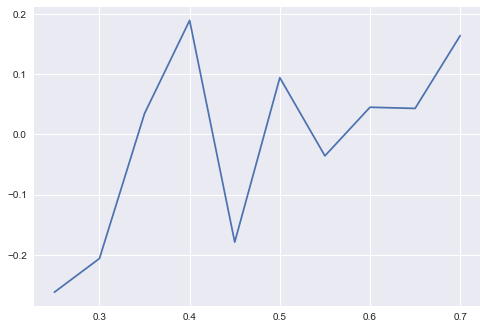

In [15]:
pl.plot(results_var['threshold'],results_var['spearman'])
pl.show()

### Drop out by cosine similarity of reps

In [242]:
def drop_cosine(X_orig, Y, drop_point):
    reps1 = X_orig[(X_orig['BioRep'] == 1)]
    reps2 = X_orig[(X_orig['BioRep'] == 2)]
    names = []
    for i in range(len(genes)):
        if cosine_similarity(reps2.values[:,i+3].reshape(1, -1),reps1.values[:,i+3].reshape(1, -1))[0][0] < drop_point:
            names.append(genes[i])
    
    X_new = X_orig.drop(names,axis=1)

    return X_new


In [16]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

reps1 = X_orig[(X_orig['BioRep'] == 1)]
reps2 = X_orig[(X_orig['BioRep'] == 2)]

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(-0.2,0.95,0.05):
    drop_point = j
    names = []

    for i in range(len(genes)):
        if cosine_similarity(reps2.values[:,i+3].reshape(1, -1),reps1.values[:,i+3].reshape(1, -1))[0][0] < drop_point:
            names.append(genes[i])
    
    X_new = X_orig.drop(names,axis=1)
    
    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_cos = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

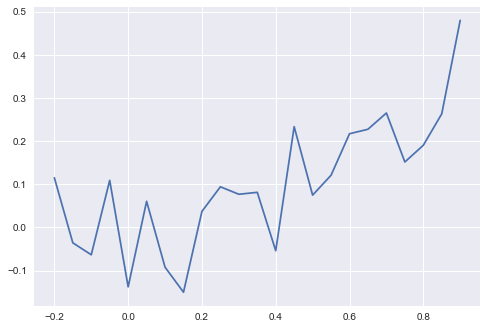

In [17]:
pl.plot(results_cos['threshold'],results_cos['spearman'])
pl.show()

### Drop out by cosine similarity of timepoints

In [261]:
def drop_cosine2(X_orig, Y, drop_point):
    names = []
    sixhr = train_data[(train_data['Timepoint'] == 0)& (train_data['Treatment'] == 0)]
    tfhr = train_data[(train_data['Timepoint'] == 1)& (train_data['Treatment'] == 0)]
    for i in range(len(genes)):
        if cosine_similarity(sixhr.values[:,i+3].reshape(1, -1),tfhr.values[:,i+3].reshape(1, -1))[0][0] < drop_point:
            names.append(genes[i])
    
    X_new = X_orig.drop(names,axis=1)

    return X_new


In [269]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

reps1 = X_orig[(X_orig['BioRep'] == 1)]
reps2 = X_orig[(X_orig['BioRep'] == 2)]

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_med = []

for j in np.arange(-0.2,0.95,0.1):
    print(j)
    X_new = drop_cosine2(X_orig, Y, j)

    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))
    cv.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_med.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring='neg_median_absolute_error')))
    
results_cos2 = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_med)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_med']) 

-0.2
-0.1
0.0
0.10000000000000003
0.2
0.3
0.4000000000000001
0.5
0.6000000000000001
0.7
0.8
0.9000000000000001


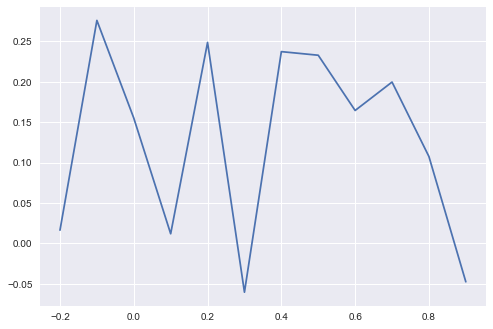

In [272]:
pl.plot(results_cos2['threshold'],results_cos2['spearman'])
pl.show()

### Drop out by correlation coefficient

In [18]:
sub = train_data[(train_data['Timepoint'] == 1) & (train_data['Treatment'] == 1)]
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

correlations = sub.corr()

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(0.1,0.55,0.05):
    drop_point = j
    names = list(correlations[abs(correlations['DHA_IC50'])<drop_point].index)
    
    X_new = X_orig.drop(names,axis=1)
    
    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_cor = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value e

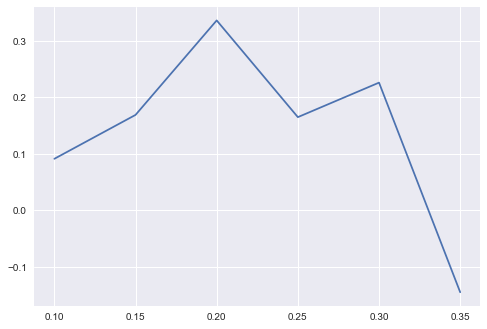

In [19]:
pl.plot(results_cor['threshold'],results_cor['spearman'])
pl.show()

### Drop out by spearman correlation coefficient

In [20]:
sub = train_data[(train_data['Timepoint'] == 1) & (train_data['Treatment'] == 1)]
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

correlations = sub.corr(method='spearman')

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(0.1,0.55,0.05):
    drop_point = j
    names = list(correlations[abs(correlations['DHA_IC50'])<drop_point].index)
    
    X_new = X_orig.drop(names,axis=1)
    
    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_scor = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value e

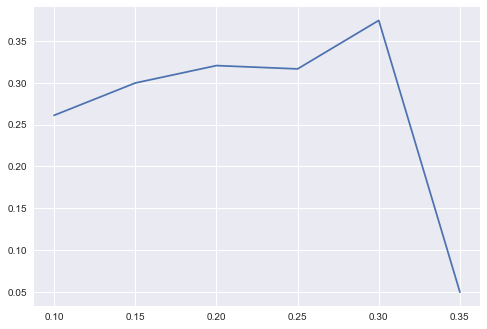

In [39]:
pl.plot(results_scor['threshold'],results_scor['spearman'])
pl.show()

### Drop out by MAD

In [222]:
def drop_mad(X_orig, Y, components):
    mads = X_orig.mad(axis = 0)
    to_drop = list(mads.sort_values(ascending=True)[:-components].index)
    X_new = X_orig.drop(to_drop,axis=1)

    return X_new

In [249]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

reps1 = X_orig[(X_orig['BioRep'] == 1)]
reps2 = X_orig[(X_orig['BioRep'] == 2)]

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_med = []

for j in np.arange(10,1000,10):
    
    X_new = drop_mad(X_orig,Y,j)
    
    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))
    cv.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_med.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring='neg_median_absolute_error')))
    
results_mad = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_med)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_med']) 

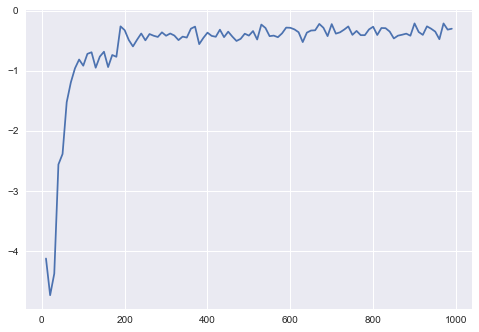

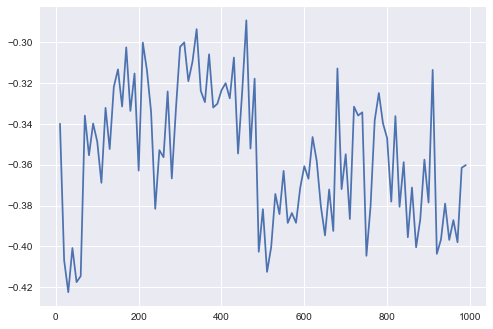

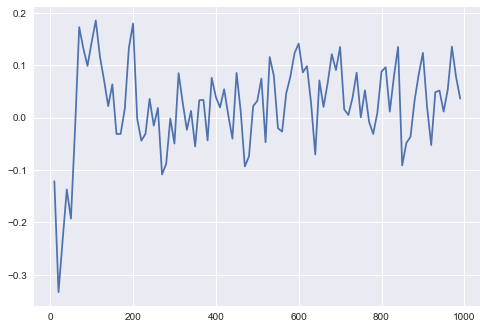

In [250]:
pl.plot(results_mad['threshold'],results_mad['accuracy'])
pl.show()
pl.plot(results_mad['threshold'],results_mad['cv_med'])
pl.show()
pl.plot(results_mad['threshold'],results_mad['spearman'])
pl.show()

### PCA

In [81]:
def drop_pca(X_orig, Y, components):
    #X_orig.drop(['BioRep'])
    X = StandardScaler().fit_transform(X_orig)
    pca = PCA(n_components=components)
    principalComponents = pca.fit_transform(X)
    X_pca = pd.DataFrame(data = principalComponents)

    return X_pca


In [22]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]
X = StandardScaler().fit_transform(X_orig)

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(5,100,5):
    pca = PCA(n_components=j)
    principalComponents = pca.fit_transform(X)
    X_pca = pd.DataFrame(data = principalComponents)
    
    max_features = min(j,50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_pca,Y,test_size=0.33,random_state=5)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_pca = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

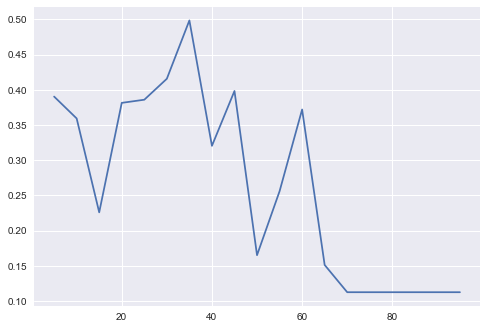

In [29]:
pl.plot(results_pca['threshold'],results_pca['spearman'])
pl.show()

### UMAP

In [11]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

X_new = umap.UMAP().fit_transform(X_orig)

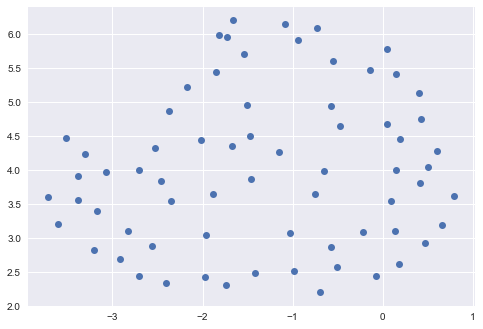

In [12]:
pl.plot(X_new[:,0],X_new[:,1],linestyle='none',marker='o')
pl.show()

### RFE
Gave NA values

In [30]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]
X = StandardScaler().fit_transform(X_orig)

max_features = 50

forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    
rfe = RFE(forest_model, max_features)
fit = rfe.fit(X, Y.values.ravel())
print(fit.n_features_)
print(fit.support_)
print(fit.ranking_)

50
[False False False ... False False False]
[5493 5492 5490 ... 5475 5479 5483]


### Univariate -- f regression

In [91]:
def drop_univ(X_orig, Y, percentile):
    X = StandardScaler().fit_transform(X_orig)
    X_uni = GenericUnivariateSelect(f_regression,'percentile', param=percentile).fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)

    return X_uni

In [131]:
def drop_univ_test(X_orig, Y, percentile,X_test):
    X = StandardScaler().fit_transform(X_orig)
    X_t = StandardScaler().fit_transform(X_test)
    uni = GenericUnivariateSelect(f_regression,'percentile', param=percentile)
    X_uni = uni.fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)
    
    X_uni_test = uni.transform(X_t)
    X_uni_test = pd.DataFrame(data = X_uni_test)

    return X_uni,X_uni_test

In [31]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]
X = StandardScaler().fit_transform(X_orig)

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(5,70,5):
    X_uni = GenericUnivariateSelect(f_regression,'percentile', param=j).fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=5)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_unif = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

/Users/shasha/miniconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/shasha/miniconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastruct

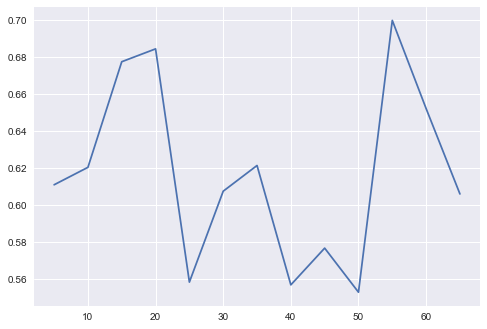

In [32]:
pl.plot(results_unif['threshold'],results_unif['spearman'])
pl.show()

### Univariate -- mutual info regression

In [35]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]
X = StandardScaler().fit_transform(X_orig)

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(5,70,5):
    X_uni = GenericUnivariateSelect(mutual_info_regression,'percentile', param=j).fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=5)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_unim = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

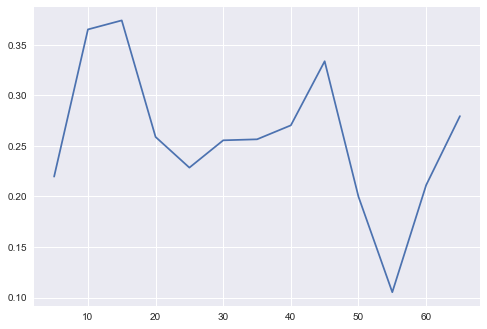

In [37]:
pl.plot(results_unim['threshold'],results_unim['accuracy'])
pl.show()

## Prediction for submission 1. Used drop by biorep and univariate f-regression on 24hr, treated data frame

In [182]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]
X_predict = test_data[(test_data['Treatment']==1)&(test_data['Timepoint'] == 1)].drop(['Sample_Names','Isolate','DHA_IC50'],axis=1)


X_temp = drop_biorep(X_orig,Y,0.75)
#X_temp = drop_cosine(X_orig,Y,0.75)

X_temp = X_temp.drop(['Treatment','Timepoint','BioRep'],axis=1)
X_predict_temp = X_predict[X_temp.columns]

#X_new = drop_pca(X_temp,Y,35)
#X_new = drop_univ(X_temp,Y,20)
X_new, X_predict_new = drop_univ_test(X_temp,Y,20,X_predict_temp)


X_train, X_test , Y_train , Y_test = train_test_split(X_new,Y,test_size=0.33,random_state=5)

forest_model = RandomForestRegressor(max_features=35,n_estimators=100, bootstrap=False,random_state = 999)
forest_model.fit(X_train, Y_train.values.ravel())
Y_pred = forest_model.predict(X_test) 


Y_pred_new = forest_model.predict(X_predict_new)
print(forest_model.score(X_test,Y_test))
print(spearmanr(Y_test,Y_pred))
print(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=3)))

0.32737052032009717
SpearmanrResult(correlation=0.6213779651167499, pvalue=0.0015521752048549356)
-0.2866013742599176


In [152]:
predictions = []
isolates = []
for i in range(int(len(Y_pred_new)/2)):
    isolates.append('isolate_'+str(i+31))
    predictions.append((Y_pred_new[2*i]+Y_pred_new[2*i+1])/2.)

In [171]:
predict = pd.DataFrame(list(zip(isolates,predictions)),columns=['Isolate','Predicted_IC50'])
predict.to_csv('SubCh1_SubmissionForm.txt', index=None, header=True,sep=' ', mode='a')
predict

,Isolate,Predicted_IC50
0,isolate_31,1.597706
1,isolate_32,1.645275
2,isolate_33,1.418026
3,isolate_34,1.575640
4,isolate_35,1.713025
5,isolate_36,1.605338
6,isolate_37,1.853349
7,isolate_38,1.855692
8,isolate_39,1.793377
9,isolate_40,1.640084


In [96]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

#X_temp = drop_biorep(X_orig,Y,0.5)
X_temp = drop_cosine(X_orig,Y,0.75)

X_temp = X_temp.drop(['Treatment','Timepoint','BioRep'],axis=1)

#X_new = drop_pca(X_temp,Y,35)
X_new = drop_univ(X_temp,Y,55)


X_train, X_test , Y_train , Y_test = train_test_split(X_new,Y,test_size=0.33,random_state=5)

forest_model = RandomForestRegressor(max_features=35,n_estimators=100, bootstrap=False,random_state = 999)
forest_model.fit(X_train, Y_train.values.ravel())
Y_pred = forest_model.predict(X_test) 

print(forest_model.score(X_test,Y_test))
print(spearmanr(Y_test,Y_pred))

0.017931761700243243
SpearmanrResult(correlation=0.37490961023803904, pvalue=0.0779548585424521)


In [183]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

X_temp = drop_biorep(X_orig,Y,0.5)
#X_temp = drop_cosine(X_orig,Y,0.75)

X_temp = X_temp.drop(['Treatment','Timepoint','BioRep'],axis=1)

X_new = drop_pca(X_temp,Y,35)
#X_new = drop_univ(X_temp,Y,55)


X_train, X_test , Y_train , Y_test = train_test_split(X_new,Y,test_size=0.33,random_state=5)

forest_model = RandomForestRegressor(max_features=35,n_estimators=100, bootstrap=False,random_state = 999)
forest_model.fit(X_train, Y_train.values.ravel())
Y_pred = forest_model.predict(X_test) 

print(forest_model.score(X_test,Y_test))
print(spearmanr(Y_test,Y_pred))

-1.2655085768822358
SpearmanrResult(correlation=0.38036464424943905, pvalue=0.07338506425651559)


In [187]:
X_new[0].head()

0    74.667885
1     8.051266
2    -0.985845
3   -45.456922
4   -10.549034
Name: 0, dtype: float64

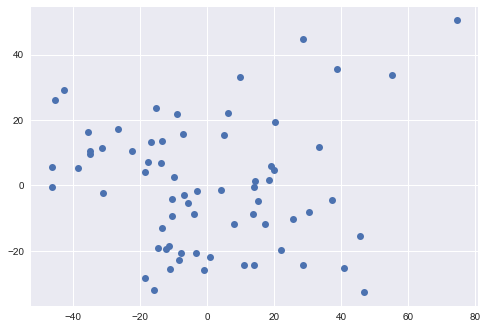

In [186]:
pl.plot(X_new[0],X_new[2],marker='o',linestyle='none')
pl.show()

In [123]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

#X_temp = drop_biorep(X_orig,Y,0.5)
X_temp = drop_cosine(X_orig,Y,0.75)
X_temp = X_temp.drop(['Treatment','Timepoint','BioRep'],axis=1)

X_new = drop_pca(X_temp,Y,35)
#X_new = drop_univ(X_temp,Y,55)


X_train, X_test , Y_train , Y_test = train_test_split(X_new,Y,test_size=0.33,random_state=5)

forest_model = RandomForestRegressor(max_features=35,n_estimators=100, bootstrap=False,random_state = 999)
forest_model.fit(X_train, Y_train.values.ravel())
Y_pred = forest_model.predict(X_test)

print(forest_model.score(X_test,Y_test))
print(spearmanr(Y_test,Y_pred))


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [118]:
Y.describe()

,DHA_IC50
count,68.000000
mean,1.570315
std,0.537390
min,0.693300
25%,1.348000
50%,1.582000
75%,1.820000
max,3.460000


## Pipeline

In [ ]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)